In [23]:
import json
import matplotlib.pyplot as plt
from schema import (
    BackendConfig,
    CornserveConfig,
    ExperimentConfig,
    VLLMConfig,
    PDConfig,
    EPDConfig,
)
import numpy as np

In [24]:
def plot_cdfs(exps: list[ExperimentConfig]):
    for exp in exps:
        if not exp.exists():
            raise ValueError("Invalid Exp config")
    data_list = [exp.load() for exp in exps]
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 6))
    for cfg, data in zip(exps, data_list, strict=True):
        # draw a CDF line
        results = data["results"]
        latencies = [r["latency"] for r in results if r["latency"] > 0]
        latencies.sort()
        n = len(latencies)
        cdf = np.arange(1, n + 1) / n
        backend_config = cfg.backend_config
        backend_config_str = ""
        if isinstance(backend_config, VLLMConfig):
            backend_config_str += f"{backend_config.num_replicas}*TP{backend_config.tp_size} Monolith"
        elif isinstance(backend_config, CornserveConfig):
            backend_config_str += f"{backend_config.num_erics}E{backend_config.num_vllms}*TP{backend_config.vllm_tp_size} E/PD"
        ax.plot(latencies, cdf, marker=".", markersize=0.0001, label=f"{backend_config_str} - rate {cfg.request_rate}")
    ax.set_xlabel("Latency (s)")
    ax.set_ylabel("CDF")
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)
    ax.set_title(f"Latency CDF {cfg.model_id} in{cfg.input_len} out{cfg.output_len} img{cfg.image_width}*{cfg.image_height}*{cfg.image_count}*{cfg.image_probability}")
    plt.show()

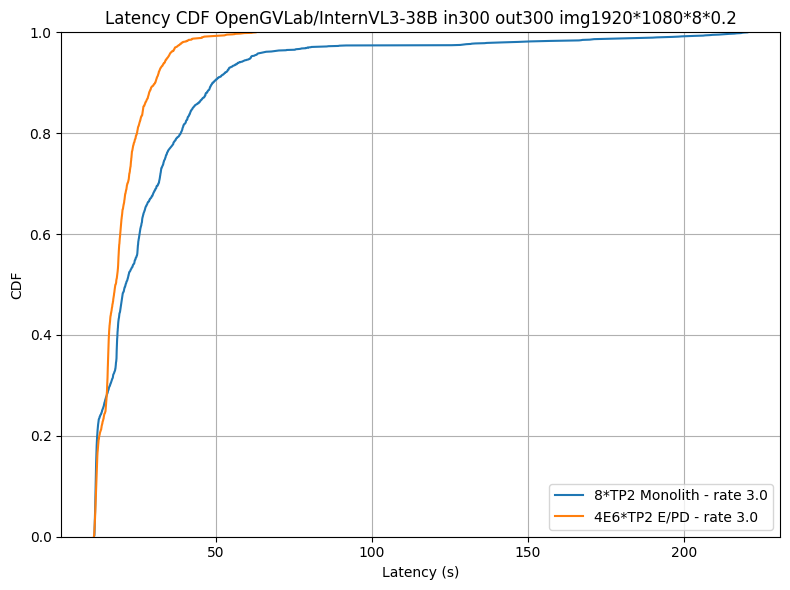

In [31]:
workloads = [(1920, 1080, 8, 0.2, 300, 300, 2000, (4,4,4,4), 1)]
model_id = "OpenGVLab/InternVL3-38B"
vllm_config = VLLMConfig(num_replicas=8, tp_size=2)
cornserve_config = CornserveConfig(num_vllms=7, vllm_tp_size=2, num_erics=2)
cornserve_config2 = CornserveConfig(num_vllms=6, vllm_tp_size=2, num_erics=4)
workload = workloads[0]
image_width, image_height, image_count, image_prob, input_len, output_len, num_prompts, rates, encoder_fission_probability = workload
(el, l, pd, epd) = rates
gpu_type="A100"
vllm_config = ExperimentConfig(
    backend_config=vllm_config,
    app_id="",
    model_id=model_id,
    request_rate=l,
    input_len=input_len,
    output_len=output_len,
    image_count=image_count,
    num_prompts=num_prompts,
    image_width=image_width,
    image_height=image_height,
    image_probability=image_prob,
    gpu_type=gpu_type,
    encoder_fission_probability=1
)
el_config = ExperimentConfig(
    backend_config=cornserve_config,
    app_id="",
    model_id=model_id,
    request_rate=l,
    input_len=input_len,
    output_len=output_len,
    image_count=image_count,
    num_prompts=num_prompts,
    image_width=image_width,
    image_height=image_height,
    image_probability=image_prob,
    gpu_type=gpu_type,
    encoder_fission_probability=encoder_fission_probability
)
el_config2 = ExperimentConfig(
    backend_config=cornserve_config2,
    app_id="",
    model_id=model_id,
    request_rate=l,
    input_len=input_len,
    output_len=output_len,
    image_count=image_count,
    num_prompts=num_prompts,
    image_width=image_width,
    image_height=image_height,
    image_probability=image_prob,
    gpu_type=gpu_type,
    encoder_fission_probability=encoder_fission_probability
)
plot_cdfs([vllm_config, el_config2])